** Objective: ** 
** To develop a statistical model for predicting whether questions will be upvoted, downvoted, or closed based on their text. ** 
** To predict how long questions will take to answer. **

** Authors: Rachit Rawat, Rudradeep Guha, Vineet Nandkishore **

** Setup Environment **

In [1]:
# load required packages

# for creating dataframes from csv datasets
import pandas as pd

# for stripping stop words
from nltk.corpus import stopwords

# for TF-IDF
import math
from textblob import TextBlob as tb

# for removing HTML tags from text body
from html.parser import HTMLParser

# for counting
import collections

# for scientific computing
import numpy as np
import math

# for plotting graphs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# magic function
%matplotlib inline

# kaggle - data set files are available in the "../input/" directory
dataset_dir = "../input/"
dataset_dir_questions = "Questions.csv"
dataset_dir_answers = "Answers.csv"
dataset_dir_tags = "Tags.csv"

# for offline run
# dataset_dir = "/home/su/Downloads/stacksample"

# list the files in the dataset directory
from subprocess import check_output
print(check_output(["ls", dataset_dir]).decode("utf8"))

cachedStopWords = stopwords.words("english")



Answers.csv
Questions.csv
Tags.csv



** HTML tags Stripper class **

In [2]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

** TF-IDF helper fucntions **

In [3]:
# tf(word, blob) computes "term frequency" which is the number of times 
# a word appears in a document blob,normalized by dividing by 
# the total number of words in blob. 
# We use TextBlob for breaking up the text into words and getting the word counts.
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

# n_containing(word, bloblist) returns the number of documents containing word.
# A generator expression is passed to the sum() function.
def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

# idf(word, bloblist) computes "inverse document frequency" which measures how common 
# a word is among all documents in bloblist. 
# The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents 
# to the number of documents containing word, then take the log of that. 
# Add 1 to the divisor to prevent division by zero.
def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

# tfidf(word, blob, bloblist) computes the TF-IDF score. 
# It is simply the product of tf and idf.
def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

** pandas - load CSV into dataframe **


In [4]:
# Read CSV

# Original Dimensionality - (rows, columns)

# (1264216, 7) 
# Columns (Id, OwnerUserId, CreationDate, ClosedDate, Score, Title, Body)
# frame every 100th question (resource restraints)
questions_df = pd.read_csv(dataset_dir+dataset_dir_questions, encoding='latin1').iloc[::100, :]

# (2014516, 6)
# Columns (Id, OwnerUserId, CreationDate, ParentId, Score, Body)
# frame every 100th answer (resource restraints)
answers_df = pd.read_csv(dataset_dir+dataset_dir_answers, encoding='latin1').iloc[::100, :]

# (3750994, 2)
# Columns (Id, Tag)
# frame every 100th tag (resource restraints)
tags_df = pd.read_csv(dataset_dir+dataset_dir_tags, encoding='latin1').iloc[::100, :]

** Sample dataframe before stripping **

In [5]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10) 
# answers_df.head(10)
# tags_df.head(10) 

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
100,10260,203.0,2008-08-13T19:18:07Z,NaN,6,What are the useful new ASP.NET features in th...,<p>I've kept up to date with new features in t...
200,18450,2018.0,2008-08-20T17:57:44Z,2015-06-09T19:54:59Z,307,Is Mono ready for prime time?,"<p>Has anyone used Mono, the open source .NET ..."
300,29100,NaN,2008-08-26T22:28:22Z,NaN,5,How are you generating tests from specifications?,"<p>I came across a printed <a href=""http://www..."
400,36030,3750.0,2008-08-30T15:15:01Z,NaN,0,Yaws uses old config file,<p>I'm developing a web app on Yaws 1.65 (inst...
500,44780,3475.0,2008-09-04T21:05:31Z,NaN,2,What's the best way to implement a SQL script ...,<p>What's the best way to implement a SQL scri...
600,52430,5201.0,2008-09-09T17:33:28Z,NaN,0,SQL Server best way to calculate datediff betw...,<p>I've got the following rough structure:</p>...
700,59380,6140.0,2008-09-12T15:50:38Z,NaN,4,Wildcard Subdomain Exceptions,<p>I have a wildcard subdomain enabled and dyn...
800,65800,1115144.0,2008-09-15T19:10:13Z,2013-10-27T22:48:48Z,12,What's the best HTML WYSISYG editor available ...,<p>There are many different flavored HTML WYSI...
900,74190,12872.0,2008-09-16T16:22:29Z,NaN,3,Can you have more than one ASP.NET State Serve...,<p>We have a 4 server cluster running ASP.NET ...


** Strip HTML tags and stop words from text body **

In [6]:
 # Remove HTML tags and stop words from body and title column
for index, row in questions_df.iterrows():
    questions_df.at[index, 'Body']= ' '.join([word for word in strip_tags(row[6]).split() if word not in cachedStopWords])
    questions_df.at[index, 'Title']= ' '.join([word for word in strip_tags(row[5]).split() if word not in cachedStopWords])

# Remove HTML tags and stop words from body column
for index, row in answers_df.iterrows():
    answers_df.at[index, 'Body']= ' '.join([word for word in strip_tags(row[5]).split() if word not in cachedStopWords]) 

** Sample dataframe after stripping **

In [7]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10)
# answers_df.head(10)
# tags_df.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries one ...,I've written database generation script SQL wa...
100,10260,203.0,2008-08-13T19:18:07Z,NaN,6,What useful new ASP.NET features .NET Framewor...,I've kept date new features C# language it's m...
200,18450,2018.0,2008-08-20T17:57:44Z,2015-06-09T19:54:59Z,307,Is Mono ready prime time?,"Has anyone used Mono, open source .NET impleme..."
300,29100,NaN,2008-08-26T22:28:22Z,NaN,5,How generating tests specifications?,I came across printed article Bertrand Meyer s...
400,36030,3750.0,2008-08-30T15:15:01Z,NaN,0,Yaws uses old config file,I'm developing web app Yaws 1.65 (installed ap...
500,44780,3475.0,2008-09-04T21:05:31Z,NaN,2,What's best way implement SQL script grant per...,What's best way implement SQL script grant sel...
600,52430,5201.0,2008-09-09T17:33:28Z,NaN,0,SQL Server best way calculate datediff current...,I've got following rough structure: Object -> ...
700,59380,6140.0,2008-09-12T15:50:38Z,NaN,4,Wildcard Subdomain Exceptions,I wildcard subdomain enabled dynamically parse...
800,65800,1115144.0,2008-09-15T19:10:13Z,2013-10-27T22:48:48Z,12,What's best HTML WYSISYG editor available web ...,There many different flavored HTML WYSIWYG edi...
900,74190,12872.0,2008-09-16T16:22:29Z,NaN,3,Can one ASP.NET State Server Service cluster?,We 4 server cluster running ASP.NET web applic...


** Make a TF-IDF word dictionary (for 5 questions) **

In [8]:
i=1
tfidf_dict={}
bloblist=[]

for index, row in questions_df.iterrows():
    bloblist.append(tb(row[6]))
    if i==5:
        break
    i+=1

for i, blob in enumerate(bloblist):
    print("Top words in question {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))
        tfidf_dict[word]=round(score, 5)

Top words in question 1
	Word: integer, TF-IDF: 0.04581
	Word: varchar, TF-IDF: 0.02863
	Word: var, TF-IDF: 0.02863
Top words in question 2
	Word: features, TF-IDF: 0.0561
	Word: 1, TF-IDF: 0.0374
	Word: ASP.NET, TF-IDF: 0.0374
Top words in question 3
	Word: Mono, TF-IDF: 0.03818
	Word: compatible, TF-IDF: 0.03818
	Word: enough, TF-IDF: 0.03818
Top words in question 4
	Word: tests, TF-IDF: 0.05236
	Word: specifications, TF-IDF: 0.05236
	Word: How, TF-IDF: 0.05236
Top words in question 5
	Word: old, TF-IDF: 0.02427
	Word: config, TF-IDF: 0.02427
	Word: back, TF-IDF: 0.02427


** Sample TF-IDF dictionary **

In [9]:
for k, v in tfidf_dict.items():
    print(k, v)

integer 0.04581
varchar 0.02863
var 0.02863
features 0.0561
1 0.0374
ASP.NET 0.0374
Mono 0.03818
compatible 0.03818
enough 0.03818
tests 0.05236
specifications 0.05236
How 0.05236
old 0.02427
config 0.02427
back 0.02427


# Initial analysis

** Top 10 most common tags **

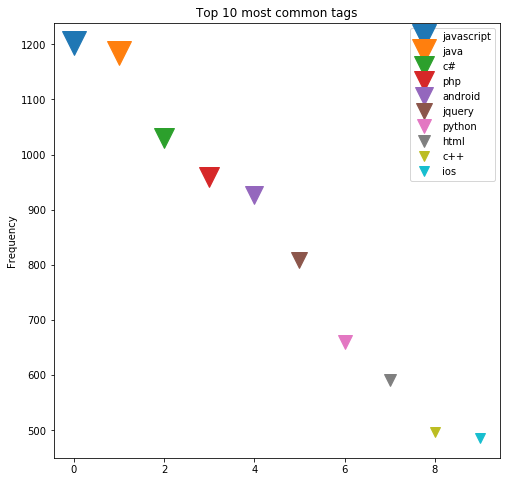

In [10]:
tags_tally = collections.Counter(tags_df['Tag'])

# x = tag name, y = tag frequency
x, y = zip(*tags_tally.most_common(10))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

area = [i/50 for i in list(y)]   # 0 to 15 point radiuses
plt.figure(figsize=(8,8))
plt.ylabel("Frequency")
plt.title("Top 10 most common tags")
for i in range(len(y)):
        plt.plot(i,y[i], marker='v', linestyle='',ms=area[i],label=x[i])

plt.legend(numpoints=1)
plt.show()

![](http://)![](http://)**Distribution  - number of answers per question**

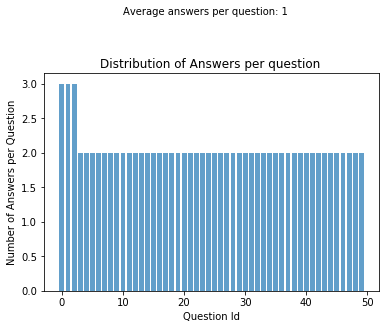

In [11]:
ans_per_question = collections.Counter(answers_df['ParentId'])
answerid,noAnswers= zip(*ans_per_question.most_common())

N=50
plt.bar(range(N), noAnswers[:N], align='center', alpha=0.7)
#plt.xticks(y_pos, objects)

plt.ylabel('Number of Answers per Question')
plt.xlabel('Question Id')
plt.title('Distribution of Answers per question ')
plt.text(10,4,"Average answers per question: "+str(math.floor((np.mean(noAnswers)))))

plt.show()